# Exercie sur dataset EEG 

1h30

Approche simple d'un dataset EEG en 4 étapes:

  * Ouvrir un fichier : signaux/triggers
  * filtrer les signaux
  * se créer un viewer

  * faire des ERP : moyenne des signaux autour des triggers (évenements) en fonction des labels du trigger




# Etape 1: lecture des datas

  * Installer un module python qui commence par **n**  et qui finit par **o**
  * Ouvrir le fichier **File_micromed_1.TRC** acquis via un système micromed.
  * Avec matplotlib afficher vite fait quelques channels sur quelques secondes + triggers
  



# Solution étape 1

In [1]:
import neo
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
filename = './data/File_micromed_1.TRC'
reader = neo.MicromedIO(filename=filename)
print(reader)

#bl = reader.read_block()
#print('nb segment', len(bl.segments))
#seg = bl.segments[0]  # Ici, un seul segment (un seul enregistrement)

seg = reader.read_segment()
print('seg : ', seg)
#seg = reader.read_segment(signal_group_mode='split-all')
#print('seg : ', seg)
#seg = reader.read_segment(signal_group_mode='group-by-same-units')


print('*'*10)
print('signals')
for anasig in seg.analogsignals:
    print('    ',anasig.name, anasig.shape, anasig.units, anasig.annotations)
print('*'*10)
print('events')
for ev in seg.events:
    print('   ', ev.name, ev.times.shape, np.unique(ev.labels))

print('*'*10)
print('epochs')
for ep in seg.epochs:
    print('   ', ep.name, ep.times.shape, ep.durations.shape, np.unique(ev.labels))


MicromedIO: ./data/File_micromed_1.TRC
nb_block: 1
nb_segment:  [1]
signal_streams: [Signals (chans: 64)]
signal_channels: [FP1, FP2, AF7, AF3 ... Trig , VEOG , HEOG , EMG]
spike_channels: []
event_channels: [Trigger, Note, Event A, Event B]

seg :  <neo.core.segment.Segment object at 0x000001F927BBD4C0>
**********
signals
     Signals (1000, 64) 1.0 uV {'stream_id': '0'}
**********
events
    Trigger (4,) ['1']
    Note (0,) []
**********
epochs
    Event A (0,) (0,) []
    Event B (0,) (0,) []


In [8]:
fig, ax = plt.subplots()

for chan in [0, 15, 50]:
    ax.plot(anasig.times.rescale('ms'), anasig[:, chan])

for t in seg.events[0].times:
    ax.axvline(t.rescale('ms'))

<IPython.core.display.Javascript object>

[[-2.20214844e+02]
 [-2.17578125e+02]
 [-2.08984375e+02]
 [-2.00585938e+02]
 [-1.28125000e+02]
 [-1.08691406e+02]
 [-1.15039062e+02]
 [-9.59960938e+01]
 [-3.95507812e+01]
 [-5.46875000e+01]
 [-4.96093750e+01]
 [-5.13671875e+01]
 [-4.94140625e+01]
 [-7.56835938e+01]
 [-1.27636719e+02]
 [-1.41210938e+02]
 [-1.98828125e+02]
 [-1.53613281e+02]
 [-8.11523438e+01]
 [-7.47070312e+01]
 [-6.96289062e+01]
 [-5.05859375e+01]
 [-4.90234375e+01]
 [-8.45703125e+01]
 [-9.38476562e+01]
 [-1.64843750e+02]
 [-2.03613281e+02]
 [-1.84277344e+02]
 [-1.63867188e+02]
 [-1.56933594e+02]
 [-2.05371094e+02]
 [-1.53710938e+02]
 [-1.43945312e+02]
 [-2.06054688e+02]
 [-1.66406250e+02]
 [-1.59082031e+02]
 [-1.90527344e+02]
 [-2.13964844e+02]
 [-2.34082031e+02]
 [-2.34765625e+02]
 [-1.83105469e+02]
 [-7.11914062e+01]
 [-1.11914062e+02]
 [-1.61523438e+02]
 [-1.55761719e+02]
 [-1.30566406e+02]
 [-1.57031250e+02]
 [-1.35546875e+02]
 [-1.30761719e+02]
 [-1.65625000e+02]
 [-1.10937500e+02]
 [-7.80273438e+01]
 [-1.3730468

ValueError: Array annotations should only be 1-dimensional

In [9]:
#anasig = seg.analogsignals[0]
triggers = seg.events[0]

# Plot de 3 cannaux :
channels = [0, 15, 20]

fig, ax = plt.subplots()
ax.plot(anasig.times.rescale('ms'), anasig[:, channels])

# Ajout des triggers
labels = [b'1', b'2']             #Si on avait plusieurs triggers différents.. (pas le cas ici)
colors = {b'1':'r', b'2':'b'}

for label in labels:
    sel = triggers.labels == label
    print('label', label, 'nb', np.sum(sel))
    times = triggers.times[sel].rescale('ms')
    for t in times:
        ax.axvline(t, color=colors[label])

ax.legend(['Chan 0', 'Chan 15', 'Chan 30', 'Trig1'], loc='best')
#ax.set_xlim(2., 3.)


<IPython.core.display.Javascript object>

ValueError: Incorrect length of array annotation: 1 != 3

# Etape 2: scpetre et filtrage des signaux

Il y a un comme d'hab du 50Hz.

Avec scipy.signal:

  * afficher les spectres
  * filtrer les siganux entre 0.5 - 49 Hz
  
Tips:
 
   * Attention scipy.signal.filtfilt plutôt que lfilter
   

# solution étape 2

In [14]:
## Tracé du spectre

import scipy.signal
channels = [0, 15, 20]

# Revenenir vers du int/numpy avec la bonne unité
fe = anasig.sampling_rate.rescale('Hz').magnitude
print('fe : ', fe)
sigs = anasig.rescale('uV').magnitude 

fig, ax = plt.subplots()
for chan in channels:
    sig = sigs[:, chan]
    freqs, Pxx_den = scipy.signal.welch(sig, fs=fe, nperseg=1000)
    ax.semilogy(freqs, Pxx_den)

ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('PSD [V**2/Hz]')
#ax.set_xlim(0, 100.)
#ax.set_ylim(1, 10000.)
plt.show()
print('truc')

fe :  256.0


<IPython.core.display.Javascript object>

truc


(8, 6)


Text(0, 0.5, 'PSD [V**2/Hz]')

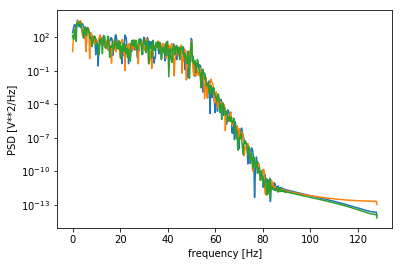

In [6]:
# Filtre du signal et plot du spectre du signal filtré

f1, f2 = 0.5, 49
band = [f1/fe*2., f2/fe*2.]

# ici filtrage avec SOS = filtrage biquad (-> execution en cascade)
coeff_sos = scipy.signal.iirfilter(8, band, analog=False,
                        btype='bandpass', ftype='butter', output='sos')
print(coeff_sos.shape)

# on filtre tous les canaux d'un seul coup avec sosfiltfilt + axis !
filtered_sigs = scipy.signal.sosfiltfilt(coeff_sos, sigs, axis=0)

# Tracé des spectres
fig, ax = plt.subplots()
for chan in channels:
    filtered_sig = filtered_sigs[:, chan]
    freqs, Pxx_den = scipy.signal.welch(filtered_sig, fs=fe, nperseg=1000)
    ax.semilogy(freqs, Pxx_den)

ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('PSD [V**2/Hz]')
#ax.set_xlim(0, 100.)
#ax.set_ylim(1, 10000.)

# Etape 3: créer un *viewer custum*

  * avec ephyviewer se créer un viewer pour se balader dans les signaux avec:
    * les signaux
    * les signaux filtrés
    * les cartes temps fréquences
    * les triggers en liste


# Etape 4 : moyenne des ERP par condition

Pour les channels [0,15,20] à partir des signaux filtrés:

  * empiler les ERP dans une fenêtre -500ms, 1500ms
  * faire la moyenne


# Mais en VRAI, utilisez Python MNE pour faire de l'EEG !

https://martinos.org/mne/stable/index.html
+
lien Neo-MNE en cours 
https://gist.github.com/agramfort/7fc27a18fcdc0e8cff3f
...